# 1. Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb ###xgboost is one of the best out of box ML models to use on tabular data and even time series problems( xgboost model is used for forecasting).
from sklearn.metrics import mean_squared_error # mean_squared_error will give us more penalty for any predictions that's way off vs just a little bit off .
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')

# 2. Types of Time Series Data

##### What is time series forecasting and different types of time series data? 
##### Reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467 (Additional information on time series forecasting in ML may be accessed here)

#### 'For this project we'll mainly use Sessional'

In [6]:
df=pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv') #read the dataset
df.head() # when we run just a head command on this , we can see just 1st few rows
# there the output we can see when we use head command , 2002 hourly energy consumption value.

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [7]:
pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df.tail() # when we run tail command on it, we can see 2018 hourly energy consumption value.

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [8]:
df=pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv') 
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

## 2.1 Visualization of The Dataset

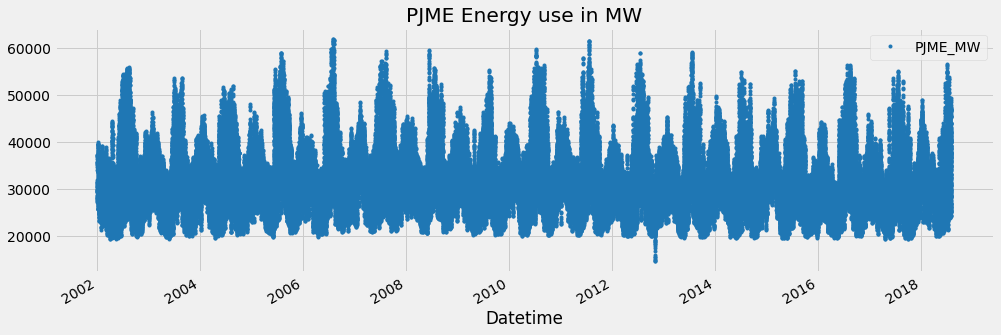

In [9]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title='PJME Energy use in MW') # for the visualization of the PJME energy consumption hourly
plt.show()

In [10]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

##### Above we can see our dtype='object' then we can just fix our data

In [ ]:
#df.index=pd.to_datetime(df.index)

In [11]:
df.index 

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# 3. Train/Test Split

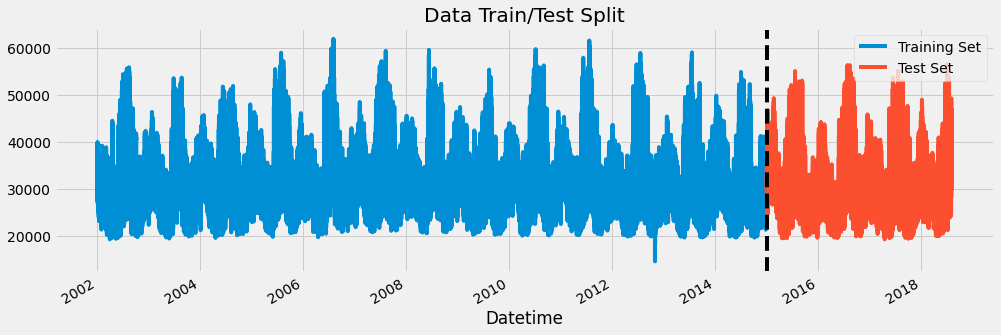

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

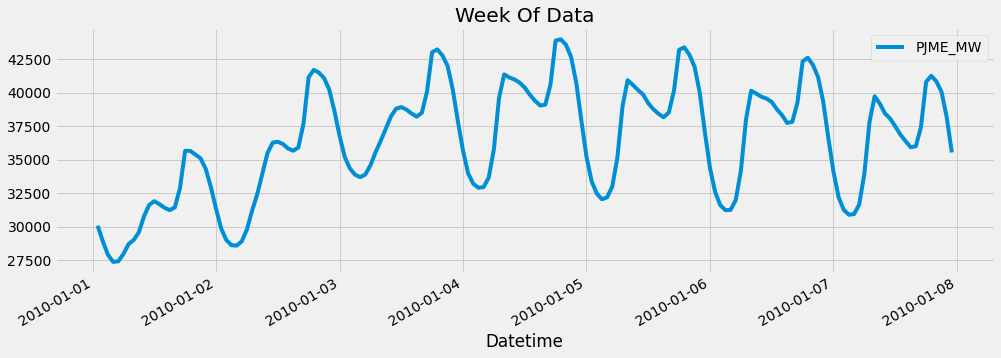

In [13]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# 4. Feature Creation

##### We're going to create some featrues with this data using the time series index.

In [14]:
df.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=145366)

##### Here, we get a number of value for each of these dates which is just the hour component

In [15]:
def create_features(df):
    # Create time series features based on time series index.
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek #(Monday=0 and Sunday=6)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 5. Feature Visualization/Target Relationship

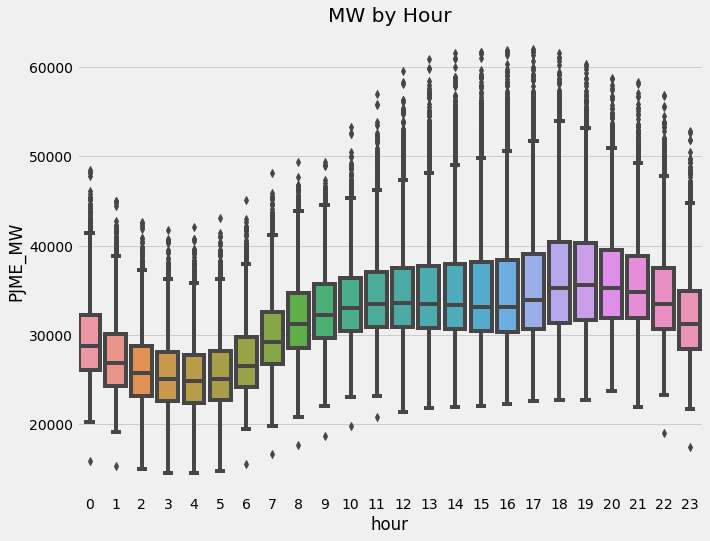

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW') #boxplot gives an idea of the distribution of a dataset
ax.set_title('MW by Hour')
plt.show()

##### We can see here early in the morning there seems to be a deep in energy use and it tends to get higher later in the evening.

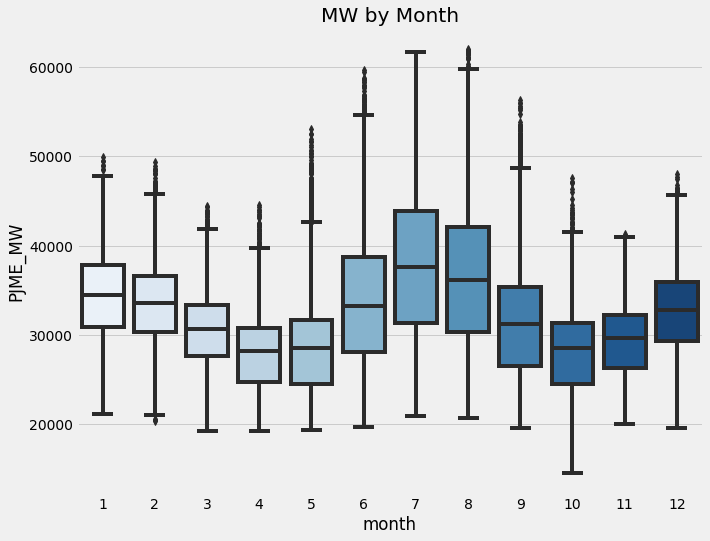

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

##### We can see that the megawatt uses by months tends to peak here two times in the winter season and then in the fall and spring  it has lower in another peak in the middle of summer

# 6. Creating Model

##### We're going to create our model based on the training data and evaluate it on the test dataset

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',   # create regression by xgb 
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:50:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[800]	validation_0-rmse:3109.24250	validation_1-rmse:3733.89694
[900]	validation_0-rmse:3079.40078	validation_1-rmse:3725.61208
[999]	validation_0-rmse:3052.73502	validation_1-rmse:3722.92243


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

# 7. Feature Importance

In [20]:
reg.feature_importances_

array([0.11356898, 0.28172174, 0.15294196, 0.05881389, 0.36996272,
       0.02299066], dtype=float32)

##### This feature importances will give us the importrance calues based on how much these features were used in each of the trees built by XGBOOST model.

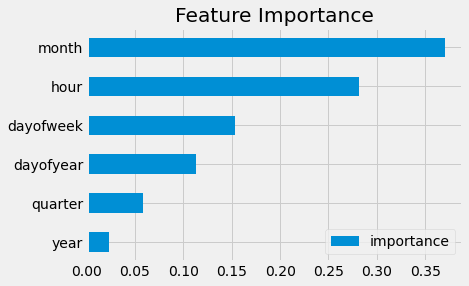

In [21]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# 8. Forecast on Test

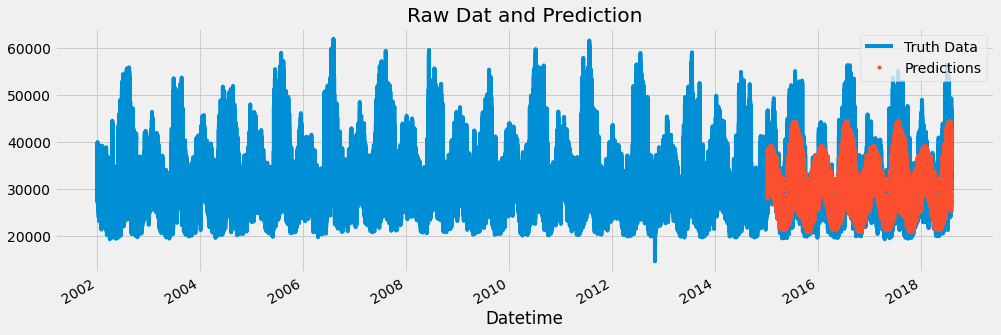

In [22]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

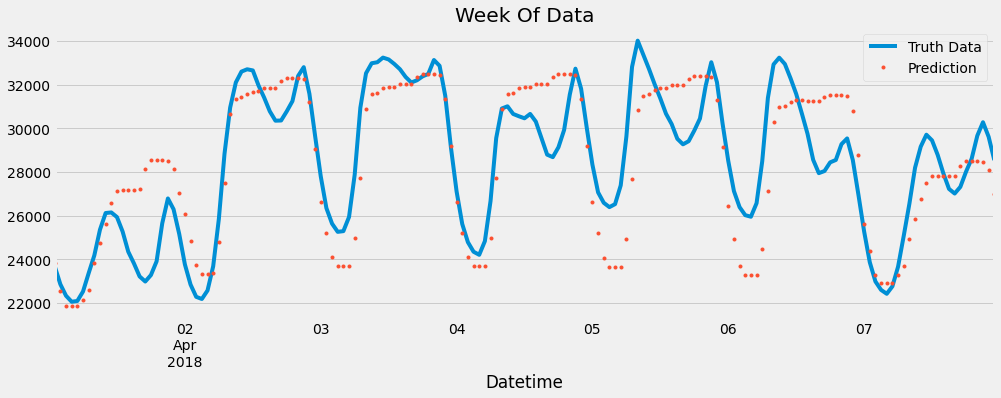

In [23]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

 ##### Plotting the prediction and ground truth over one week we can see that  the model isn't perfect .There's a lot of improvement that can be made some ideas include doing better parameter tuning we didn't tune this model at all.We could also add in features for specific days of the year like holidays that might carry forward to either increase or decrease the energy use that it would for those days.There's a lot that can be done to make this better but we could see that our predictions on the test set in this week do actually follow the trend that we would expect to see going up and down having the deeps during the night times and we can even run our evaluation metric on this by using our test.predictions.

## 8.1 Merge two Data frames

In [24]:
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42689.433594,42689.433594
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42547.429688,42547.429688
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40844.234375,40844.234375


# 9. Score (RMSE)

In [25]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

3721.7461972791516

##### Here, we're going to run the square root of the mean squared error this will get us the root mean squared error which is the same metric that we were using creatinfg model here RMSC when we're evaluating the model as it trained. 
##### So, our root mean squared error on the test set is three thousand seven hundred and fourteen to improve this model we would want to reduce that score. So, we're going to prinnt

In [26]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


# 10. Calculate the Error

### 10.1 Look at the worst and best predicted Days

In [27]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.595459
2016-08-14    12780.209554
2016-09-10    11356.302002
2015-02-20    10965.976237
2016-09-09    10864.953451
2018-01-06    10506.844889
2016-08-12    10124.050618
2015-02-21     9881.798503
2015-02-16     9781.549805
2018-01-07     9739.143555
Name: error, dtype: float64

##### By calculating error, we can see which dates are actually predict for the worst and try to improve those going forward.